# Simon's Algorithm

## Problem statement:

Given: a function $f$ acting on bit strings $f:\{0,1\}^n \rightarrow \{0,1\}^n$ and a promise that $f(x)=f(x \oplus s)$ for all $x$ (addition mod 2). The goal is to use Simon's algorithm to find the unknown string $s$.




### Example:

For example, if $n = 3$, then the following function is an example of a function that satisfies the required and just mentioned property:

|$x$|   $$f(x)$$|
|---|------|
|000|	101|
|001|	010|
|010|	000|
|011|	110|
|100|	000|
|101|	110|
|110|	101|
|111|	010|



Given $f$ is a two-to-one function i.e. it maps exactly two inputs to every unique output, and we find 2 values of input $x$ that have the same output, $f(x_1)=f(x_2)$ then it is guaranteed that $x_1 \oplus x_2 = s$

For example, the input strings $011$ and $101$ are both mapped by $f$ to the same output string $110$. If we XOR $011$ and $101$ we obtain $s$, that is:

$$011 \oplus 101 = 110$$

so for this example $s = 110$


## Problem hardness

To solve this classically, you need to find two different inputs $x$ and $y$ for which $f(x)=f(y)$. Given $f$ is a blackbox, we can discover something about $f$ (or what it does) only when, for two different inputs, we obtain the same output. In any case, we would need to guess $ \Omega ({\sqrt {2^{n}}})$ different inputs before being likely to find a pair on which $f$ takes the same output.


## Simon's Algorithm

The high-level idea behind Simon's algorithm is to "probe" a quantum circuit "enough times" to find $n-1$ (linearly independent) n-bit strings, that is

$$ y_{1},y_{2},\dots ,y_{n-1}\in \{0,1\}^{n} $$

such that the following equations are satisfied

$$ \begin{aligned}y_{1}\cdot s&=0\\y_{2}\cdot s&=0\\&\,\,\,\vdots \\y_{n-1}\cdot s&=0\end{aligned}$$ 


where $ y_{i}\cdot s$ is the modulo-2 dot product; that is, $ y_{i}\cdot s=y_{i1}s_{1}\oplus y_{i2}s_{2}\oplus \dots \oplus y_{in}s_{n} $

So, this linear system contains $n-1$ linear equations in $n$ unknowns (i.e. the bits of $s$, and the goal is to solve it to obtain $s$, and $s$ is fixed for a given function $f$.


### Simon's quantum circuit

The quantum circuit below is the implementation (and visualization) of the quantum part of Simon's algorithm.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fb/Simons_algorithm.svg"/>

The circuit acts on $2n$ qubits (where $n$ is the length of the bit string in question (i.e., $n=3$ for our example). Apply a Hadamard gate to the first $n$ qubits, then apply $U_f$ - which is an oracle (or "black box"), which knows how to compute $f$ , then apply a Hadamard gate to the first $n$ qubits.

For more details on Simon's algorithm refer to [Wikipedia](<https://en.wikipedia.org/wiki/Simon%27s_problem#Simon's_algorithm>)


## IMPORTS and SETUP

In [3]:
from braket.circuits import Circuit
from braket.devices import LocalSimulator
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Sets the device to run the circuit on
device = LocalSimulator()



### Circuit Definition

1. We start by applying Hadamard gates to the first $n$-qubits. 


2. We apply the oracle/black box ($U_f$ gate) to map to $f(x)$. Here we build it dynamically based on our chosen value of $s$. (You can experiment by setting $s$ to other values and different lengths).


3. We apply Hadamard Gate to the first $n$-qubits.


In [4]:
s = '11011'
n = len(str(s))

circ = Circuit()

## Apply Hadamard gates to first n qubits before querying the oracle 
circ.h(range(n)) 

# Generic Oracle to implement function f(x) with chosen value of s. 
# Apply cnot only for bits of s that are 1
for i in range(n):
    if int(s[i]) == 1:
        for j in range(n):
            circ.cnot(i, n + j)


# Apply Hadamard gates to the first n qbits
circ.h(range(n)) 


print(circ)

T  : |0| 1 | 2 |  3  |   4   |   5   |  6  | 7 |8|9|
                                                    
q0 : -H-C---C---C-----C-------C-------H-------------
        |   |   |     |       |                     
q1 : -H-|---|-C-|-C---|-C-----|-C-----C-----H-------
        |   | | | |   | |     | |     |             
q2 : -H-|-H-|-|-|-|---|-|-----|-|-----|-------------
        |   | | | |   | |     | |     |             
q3 : -H-|---|-|-|-|-C-|-|-C---|-|-C---|-C---C---H---
        |   | | | | | | | |   | | |   | |   |       
q4 : -H-|---|-|-|-|-|-|-|-|-C-|-|-|-C-|-|-C-|-C-C-H-
        |   | | | | | | | | | | | | | | | | | | |   
q5 : ---X---|-X-|-|-X-|-|-|-X-|-|-|-|-|-|-|-|-|-|---
            |   | |   | | |   | | | | | | | | | |   
q6 : -------X---|-X---|-|-X---|-|-|-X-|-|-|-|-|-|---
                |     | |     | | |   | | | | | |   
q7 : -----------X-----|-X-----|-|-X---|-|-X-|-|-|---
                      |       | |     | |   | | |   
q8 : -----------------X-------|-X-----|-X---|-

## Now run the circuit

In [5]:
task = device.run(circ, shots=2*n-1)

### Analyze the results

The measurements are performed on all $2n$ qubits. We are only interested in the first $n$ qubits. So we count the unique results of first $n$ qubits and plott the results

measurement_counts: Counter({'1101100000': 3, '0000000000': 3, '0000011111': 2, '1101111111': 1})

measurement_of_input_registers: {'11011': 4, '00000': 5}



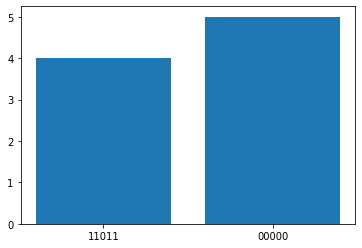

In [6]:
result = task.result()
print(f"measurement_counts: {result.measurement_counts}\n")


# Simulate partial measurement by seperating out first n bits
answer_plot = {}
for measresult in result.measurement_counts.keys():
    measresult_input = measresult[:len(str(s))]
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += result.measurement_counts[measresult]
    else:
        answer_plot[measresult_input] = result.measurement_counts[measresult] 

print(f"measurement_of_input_registers: {answer_plot}\n")
plt.bar(answer_plot.keys(), answer_plot.values())
plt.show()
        

Using these results, we can recover the value of $s$ 

In [7]:
y1,y2 = answer_plot.keys()

s_calc = int(y1)^int(y2)
    
print(f"Bitwise XOR / Dot product of the 2 results y1 and y2 retrieves our unknown string 's' --> {s_calc}\n")

Bitwise XOR / Dot product of the 2 results y1 and y2 retrieves our unknown string 's' --> 11011



In Real Qunatum devices and larger bitstrings, we might get multiple answers that satisfy the equations:
$$ \begin{aligned}y_{1}\cdot s&=0\\y_{2}\cdot s&=0\\&\,\,\,\vdots \\y_{n-1}\cdot s&=0\end{aligned}$$ 

Once we have $n$ linear equations, we proceed to post-processing with computations that can be done on classical computers using Gaussian elimination. 

The steps are as below. ( Reference : https://github.com/nallg00d/simonqiskit/blob/master/simon_algorithm.ipynb )

In [8]:
from braket.aws import AwsDevice, AwsQuantumTask
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = f"amazon-braket-251940851769" # the name of the bucket
my_prefix = "simons-output" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

# set up device
rigetti = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-8")

# run circuit with a polling time of 5 days
rigetti_task = rigetti.run(circ, s3_folder, shots=100, poll_timeout_seconds=5*24*60*60)

# get id and status of submitted task
rigetti_task_id = rigetti_task.id
rigetti_status = rigetti_task.state()
# print('ID of task:', rigetti_task_id)
print('Status of task:', rigetti_status)

Status of task: CREATED


In [13]:
status = rigetti_task.state()
print('Status of (reconstructed) task:', status)

Status of (reconstructed) task: QUEUED


In [ ]:
result = rigetti_task.result()
print(f"measurement_counts: {result.measurement_counts}\n")


# Simulate partial measurement by seperating out first n bits
answer_plot = {}
for measresult in result.measurement_counts.keys():
    measresult_input = measresult[:len(str(s))]
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += result.measurement_counts[measresult]
    else:
        answer_plot[measresult_input] = result.measurement_counts[measresult] 

print(f"measurement_of_input_registers: {answer_plot}\n")
plt.bar(answer_plot.keys(), answer_plot.values())
plt.show()
        

In [46]:
# Post-processing step
# Constructing the system of linear equations Y s = 0

lAnswer = [ (k,v) for k,v in answer_plot.items() if k != "0"*n  ] #excluding the trivial all-zero

#Sort the basis by their probabilities
lAnswer.sort(key = lambda x: x[1], reverse=True)

Y = []
for k, v in lAnswer:
    Y.append( [ int(c) for c in k ] )


#import tools from sympy
from sympy import Matrix, pprint, MatrixSymbol, expand, mod_inverse


Y = Matrix(Y)
print(Y)


#Perform Gaussian elimination on Y
Y_transformed = Y.rref(iszerofunc=lambda x: x % 2==0) # linear algebra on GF(2) 

#to convert rational and negatives in rref of linear algebra on GF(2)
def mod(x,modulus):
    numer, denom = x.as_numer_denom()
    return numer*mod_inverse(denom,modulus) % modulus

Y_new = Y_transformed[0].applyfunc(lambda x: mod(x,2)) #must takecare of negatives and fractional values
print(Y_new)

print("The hidden bistring s[ 0 ], s[ 1 ]....s[",n-1,"] is the one satisfying the following system of linear equations:")
rows, cols = Y_new.shape
for r in range(rows):
    Yr = [ "s[ "+str(i)+" ]" for i, v in enumerate(list(Y_new[r,:])) if v == 1 ]
    if len(Yr) > 0:
        tStr = " + ".join(Yr)
        print(tStr, "= 0")

Matrix([[1, 1, 0, 1, 1]])
Matrix([[1, 1, 0, 1, 1]])
The hidden bistring s[ 0 ], s[ 1 ]....s[ 4 ] is the one satisfying the following system of linear equations:
s[ 0 ] + s[ 1 ] + s[ 3 ] + s[ 4 ] = 0


As seen above, the system of linear equations is satisfied by the unknown string $s$.